Plan:
* Analzye the temperautre and currents for the 5 drifters deployed in summer AZMP 2024.
* Currents will be analyzed with rotary spectra (reference: https://jmlilly.net/course/labs/html/SpectralAnalysis_Python.html)
* Temperture - look at time series and power spectra.

In [1]:
import glob
import os

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import xarray as xr
import yaml

from plotutils.drift_correction_factor import dcf_rotary_spectra

In [2]:
drifterID_file = 'NLDrifterIDs.yaml'
with open(drifterID_file) as f:
    deployments = yaml.safe_load(f)

In [3]:
d = 'NLSummerAZMP2024'
IDs = deployments[d]
data_dir = 'INSITU_GLO_PHY_UV_DISCRETE_NRT_013_048/cmems_obs-ins_glo_phy-cur_nrt_drifter_irr_202311' 

In [4]:
def gather_data(ID):
    """Open xarray dataset for files associated with a drifter ID"""
    files = glob.glob(os.path.join(data_dir, 'monthly', '*', f'*{ID}*.nc'))
    if not files:
        files = glob.glob(os.path.join(data_dir, 'latest', '*', f'*{ID}*.nc'))
    if not files:
        print(f'No files found for ID {ID}')
        return None
    d = xr.open_mfdataset(files)
    return d

In [5]:
def plot_dataset_timeseries(d, ax, var='TEMP'):
    """Plot var timeseries for a dataset"""
    if var == 'TEMP':
        dind = 1
    if var == 'EWCT' or var == 'NSCT':
        dind = 2
    if var == 'WSPE_MODEL' or var == 'WSPN_MODEL':
        dind = 0
    dqc = d.where(d[f'{var}_QC']==1)
    data = dqc[var].isel(DEPTH=dind).values
    ax.plot(dqc.TIME, data)
    ax.set_ylabel(f'{d[var].long_name}\n[{d[var].units}]')

In [6]:
def plot_map(d,ax,vmin=4, vmax=16):
    mesh = ax.scatter(d.LONGITUDE.values, d.LATITUDE.values, c=d.sel(DEPTH=1).TEMP.values,
                      vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    return mesh

In [7]:
def plot_gridspec(d):
    fig = plt.figure(constrained_layout=True, figsize=(14,10))
    gs = fig.add_gridspec(3, 4)
    #map
    axmap = fig.add_subplot(gs[0:2, 2:], projection=ccrs.PlateCarree())
    d = gather_data(ID)
    mesh  = plot_map(d,axmap)
    cbar = plt.colorbar(mesh, ax=axmap)
    cbar.set_label(f'{d.TEMP.long_name} [{d.TEMP.units}]')
    axmap.coastlines()
    axmap.gridlines(draw_labels=['bottom', 'left'])
    #time series
    axv = fig.add_subplot(gs[2, 0:2])
    plot_dataset_timeseries(d,axv, var='NSCT')
    axv.tick_params(axis='x', labelrotation=90)
    axt = fig.add_subplot(gs[0, 0:2], )
    plot_dataset_timeseries(d,axt, var='TEMP')
    axu = fig.add_subplot(gs[1, 0:2])
    plot_dataset_timeseries(d,axu, var='EWCT')
    axt.get_xaxis().set_ticklabels([])
    axu.get_xaxis().set_ticklabels([])
    for ax in [axt, axu, axv]:
        ax.grid()
    # rotary
    P=4
    ds = d.assign({'lat': d.LATITUDE}).resample({'TIME': '1H'}).nearest(tolerance=1)
    cv = ds.sel(DEPTH=2).EWCT.values + 1j*ds.sel(DEPTH=2).NSCT.values
    dt = (ds.TIME.values[1] - ds.TIME.values[0])/np.timedelta64(1, 'D')
    f, s = dcf_rotary_spectra.calc_rotary_spectrum(cv, dt, P)
    ax1 = fig.add_subplot(gs[2,2])
    ax2 = fig.add_subplot(gs[2,3])
    axs = [ax1,ax2]
    dcf_rotary_spectra.plot_rotary_spectrum(f, s, axs, P, filled=True)
    for ax in axs:
        dcf_rotary_spectra.add_reference_lines(ax, ds)
        ax.grid()
    
    fig.suptitle(ID)
    return fig

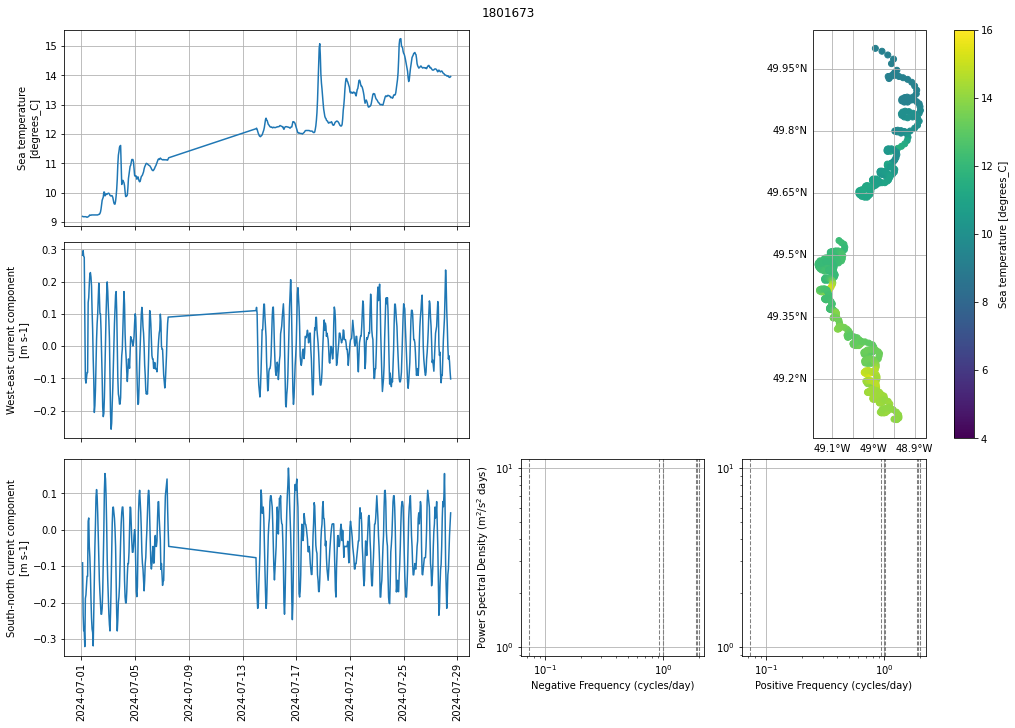

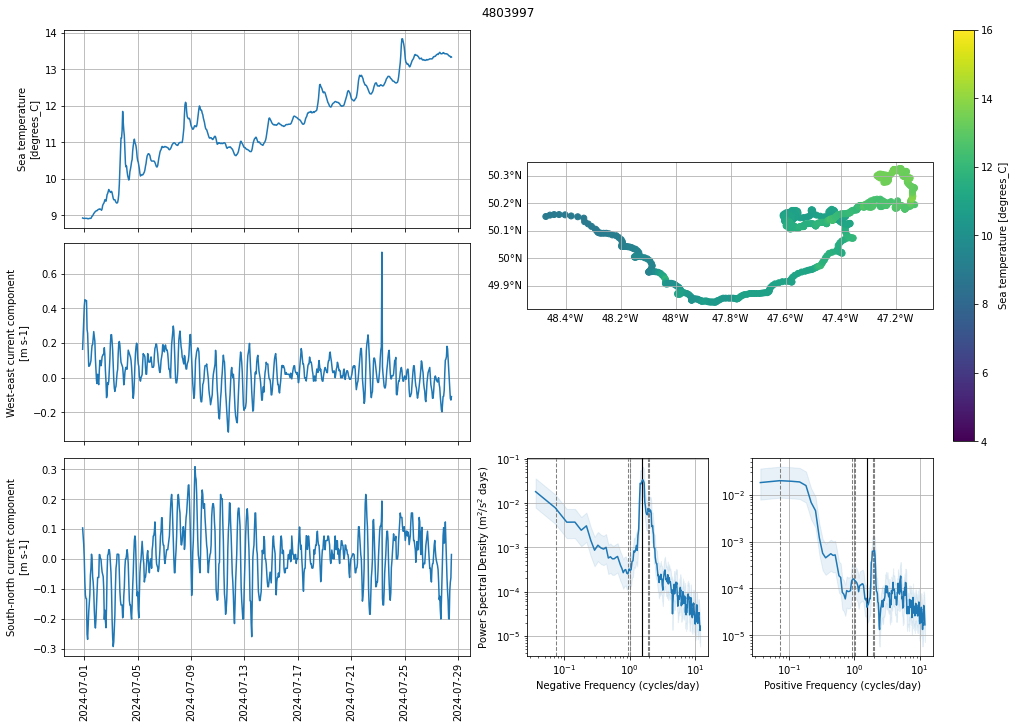

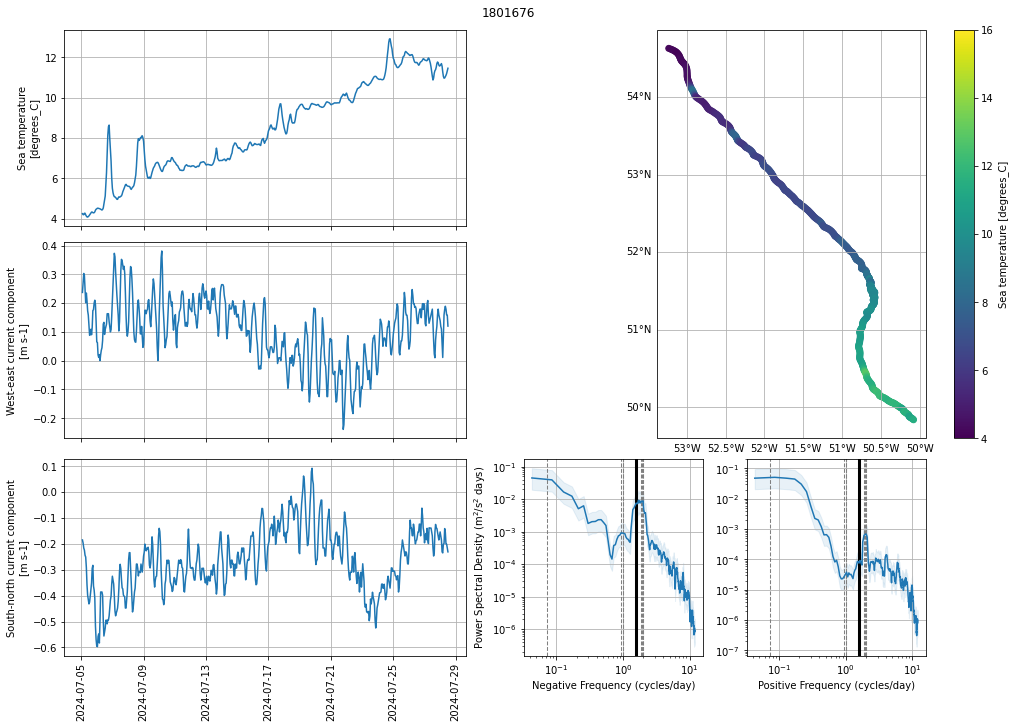

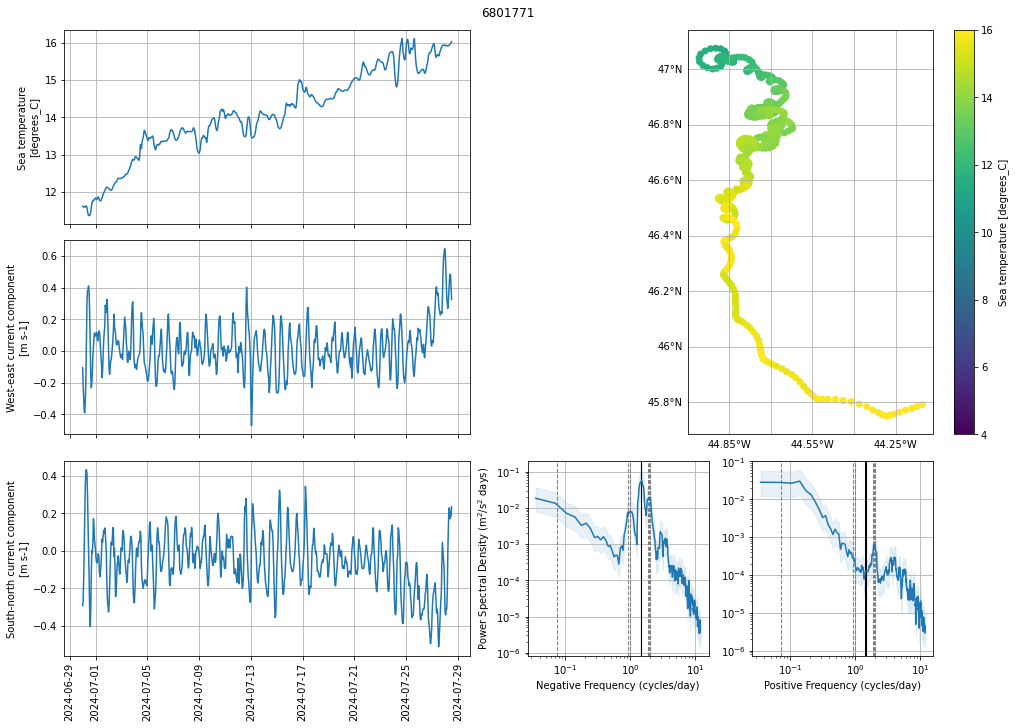

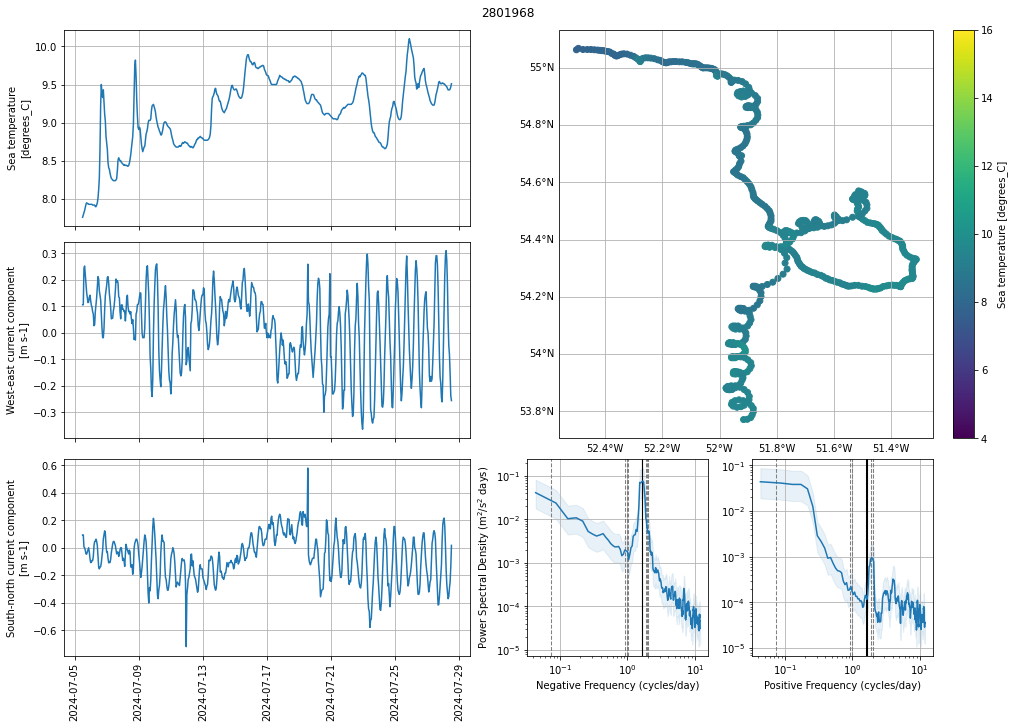

In [8]:
for ID in IDs:
    d = gather_data(ID)
    f = plot_gridspec(d)

Need to redownload - get the July monthly when it is available!

For some reason 1801673 is missing a chunk of data July 7 to 14 ish. Hopefully this issue will be addressed when downloading monthly. This explains the empty rotarty spectra plot.


# Notes on  rotary spectra calculations
* Code from drift tool which was adapted from Jonathan Lilly ( https://jmlilly.net/course/labs/html/SpectralAnalysis_Python.html)
* In plots below
  * dashed vertical lines are the dominant semi-dirunal, diurnal, and fortnightly tidal frequenices.
  * Solid lines are mean/min/max inertial frequencies over the latitudes of each drifter
  * Blue shading are 95% confidence intervals for the rotary spectrum

## Summary
* Recap on rotary spectra - negative frequencies mean clockwise rotations, positive are counter clockwise (in northern hemisphere)
* Inertial oscillations in the clockwise rotations in the northern hemisphere (because coriolis force deflects to the right)
* From plots, evidence of inertial oscillations is clear given the peak at the inertial frequency on the negative side. Furthermore, when looking at the maps, the loops are rotating clockwise, suggesting these loops are indeed inertial oscillations. 
* There are also some smaller peaks that the diurnal and semi-diurnal tidal frequencies 

# Now the Students on Ice SVPS

In [9]:
d = 'StudentsonIce2024'
IDs = deployments[d]
data_dir = 'INSITU_GLO_PHY_UV_DISCRETE_NRT_013_048/cmems_obs-ins_glo_phy-cur_nrt_drifter_irr_202311' 

No files found for ID 3801759
No files found for ID 6801975
No files found for ID 2802157
No files found for ID 2802158
No files found for ID 7811001
No files found for ID 2802159


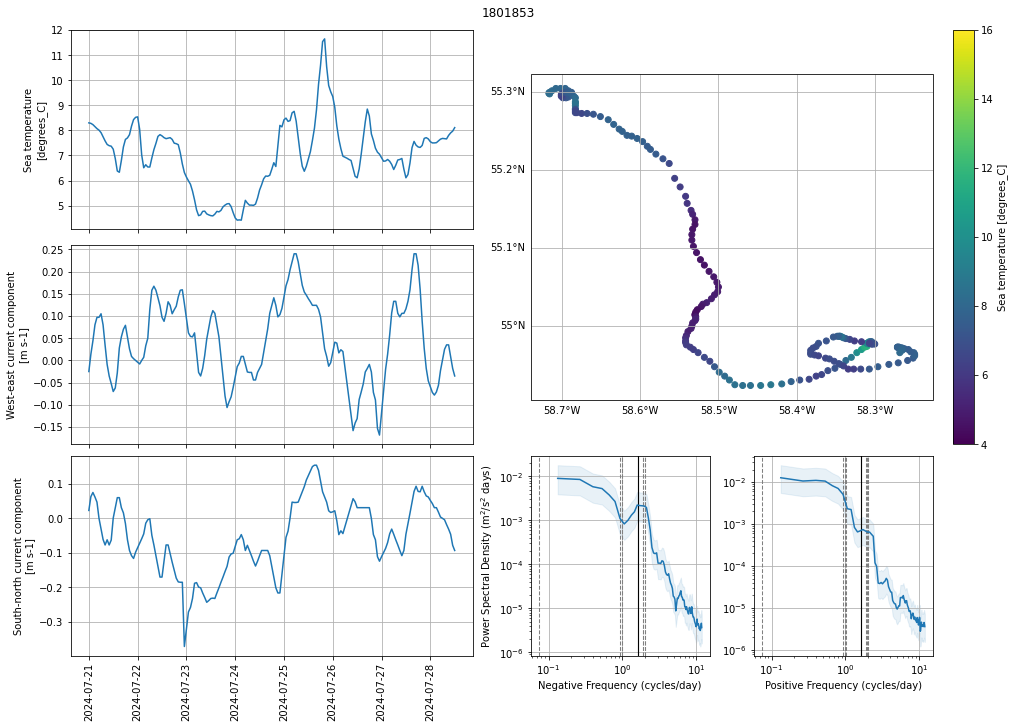

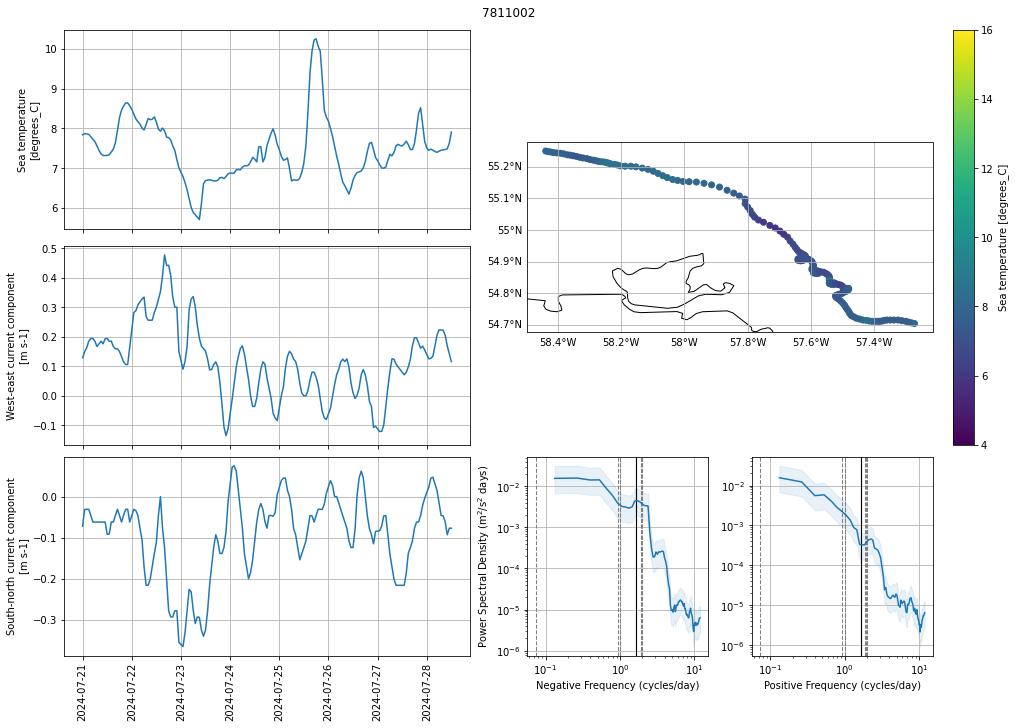

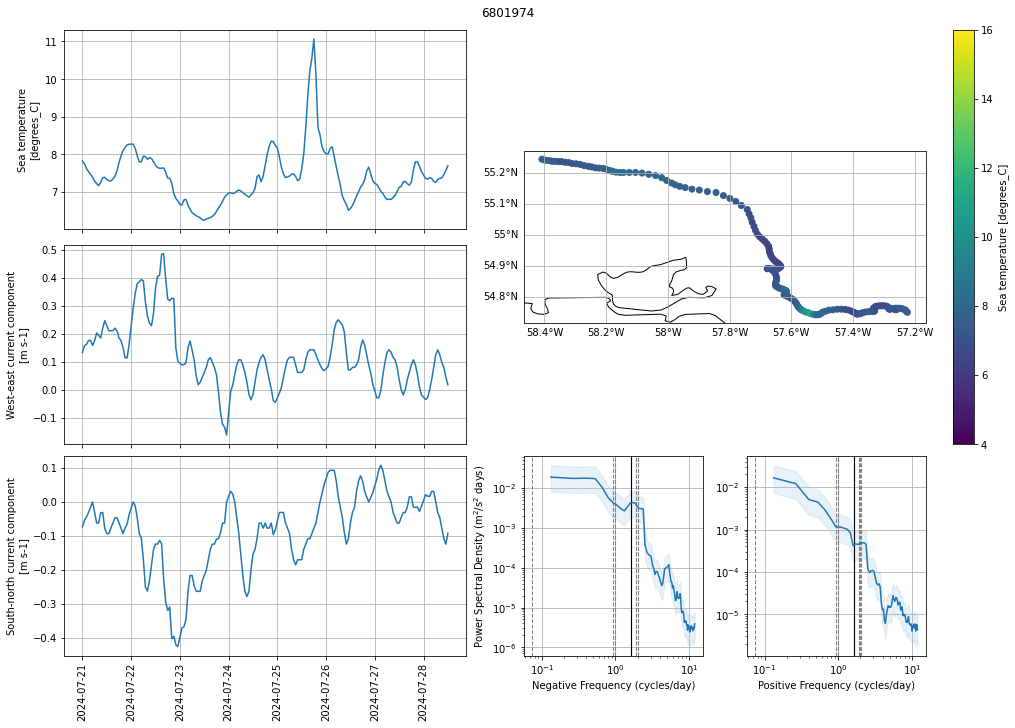

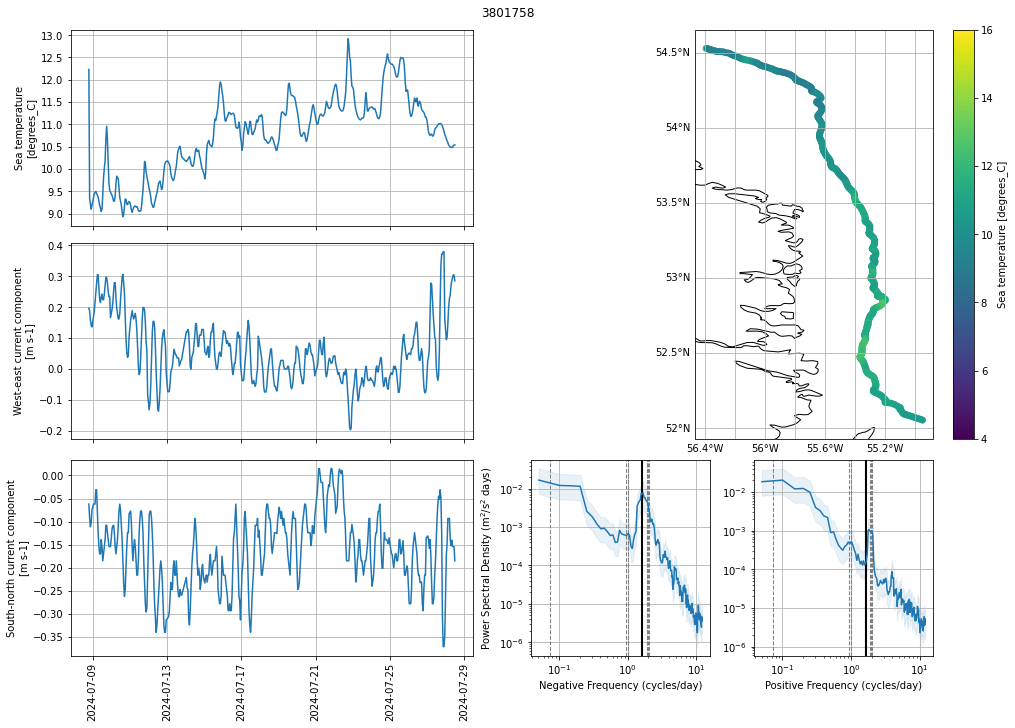

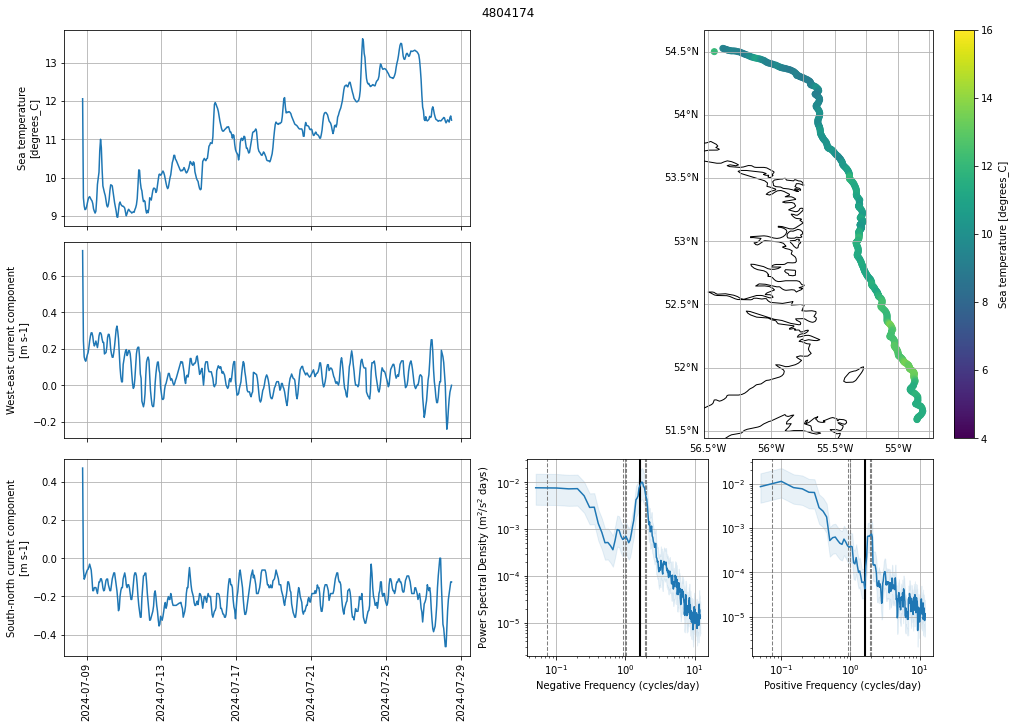

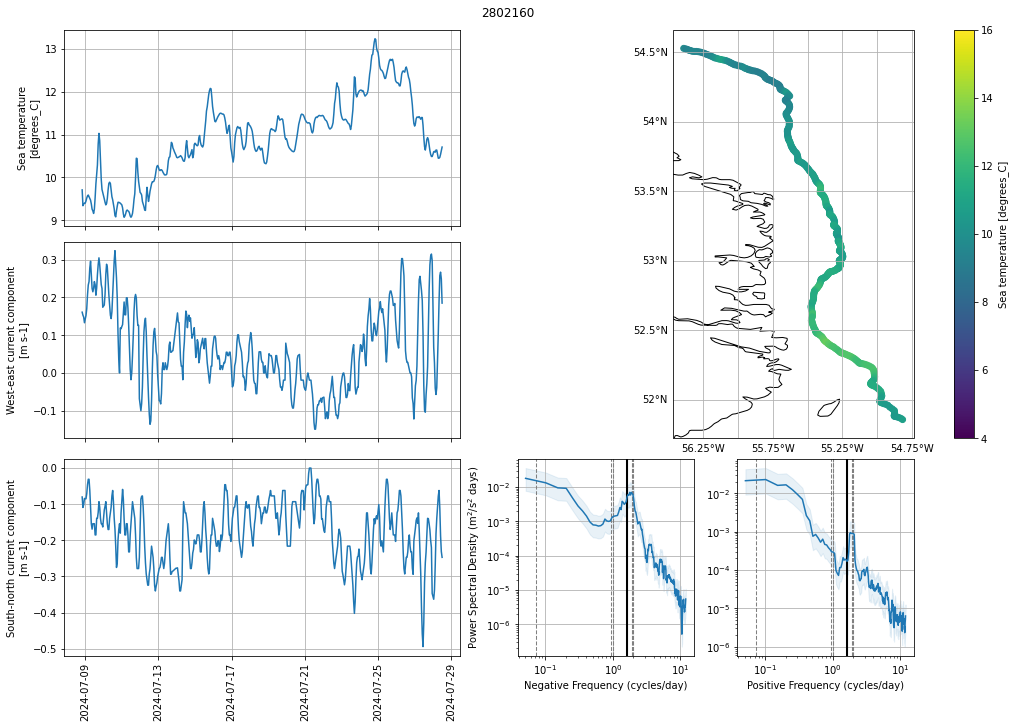

In [10]:
for ID in IDs:
    d = gather_data(ID)
    if not d: 
        continue
    f = plot_gridspec(d)

## Summary
* some for the time series aren't long enough to really do a good rotary spectra
* Otherwise, same finding that inertial frequency is dominant, with smaller peaks asscoiated with diurnal tides


# Temperature power spectrum
Just quickly, for interest sakes to see if anything stands out.  I probably need to think more about detrending ....

No files found for ID 3801759


/home/soontiensn/miniconda-new/envs/develop/lib/python3.9/site-packages/scipy/signal/spectral.py:1964: UserWarning: nperseg = 256 is greater than input length  = 181, using nperseg = 181
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/soontiensn/miniconda-new/envs/develop/lib/python3.9/site-packages/scipy/signal/spectral.py:1964: UserWarning: nperseg = 256 is greater than input length  = 181, using nperseg = 181
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/soontiensn/miniconda-new/envs/develop/lib/python3.9/site-packages/scipy/signal/spectral.py:1964: UserWarning: nperseg = 256 is greater than input length  = 181, using nperseg = 181
  warnings.warn('nperseg = {0:d} is greater than input length '


No files found for ID 6801975
No files found for ID 2802157
No files found for ID 2802158
No files found for ID 7811001
No files found for ID 2802159


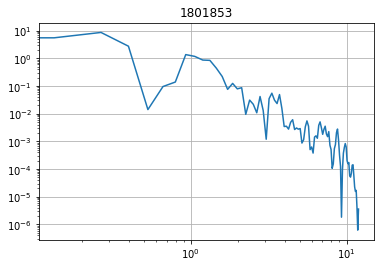

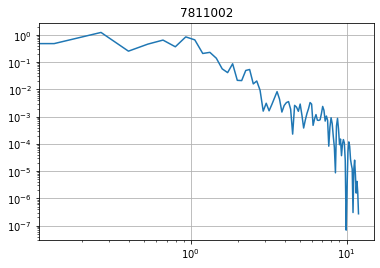

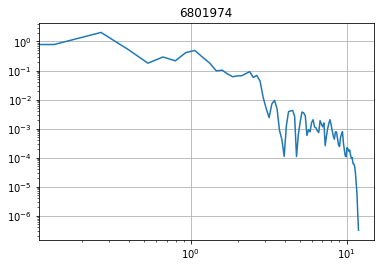

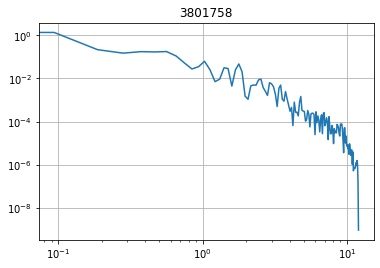

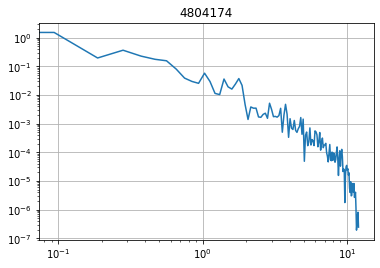

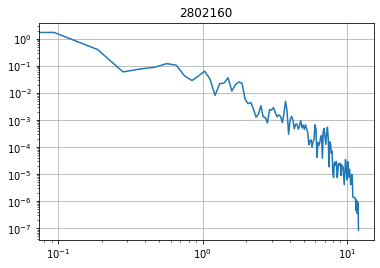

In [11]:
import scipy.signal
for ID in IDs:
    d = gather_data(ID)
    if not d:
        continue
    ds = d.assign({'lat': d.LATITUDE}).resample({'TIME': '1H'}).nearest(tolerance=1)
    dt = (ds.TIME.values[1] - ds.TIME.values[0])/np.timedelta64(1, 'D')
    data = ds.sel(DEPTH=1)['TEMP'].values

    f, Pxx = scipy.signal.welch(data, 1/dt)
    
    fig,ax = plt.subplots(1,1)
    ax.loglog(f,Pxx)
    ax.grid()
    ax.set_title(ID)

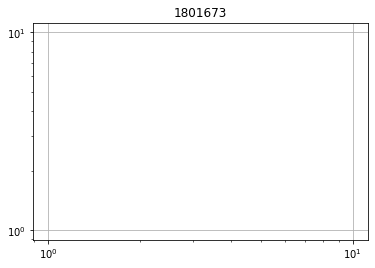

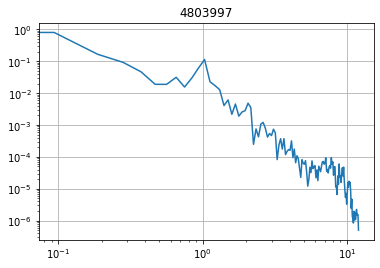

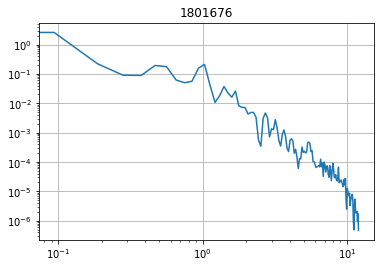

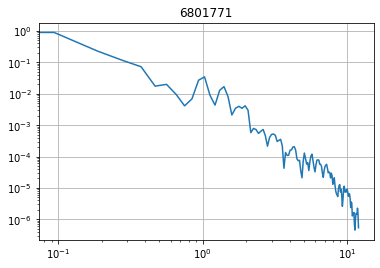

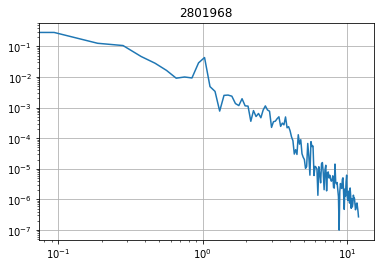

In [12]:
d = 'NLSummerAZMP2024'
IDs = deployments[d]
import scipy.signal
for ID in IDs:
    d = gather_data(ID)
    if not d:
        continue
    ds = d.assign({'lat': d.LATITUDE}).resample({'TIME': '1H'}).nearest(tolerance=1)
    dt = (ds.TIME.values[1] - ds.TIME.values[0])/np.timedelta64(1, 'D')
    data = ds.sel(DEPTH=1)['TEMP'].values

    f, Pxx = scipy.signal.welch(data, 1/dt)
    
    fig,ax = plt.subplots(1,1)
    ax.loglog(f,Pxx)
    ax.grid()
    ax.set_title(ID)